In [3]:
import copy
import time
from math import ceil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_utils

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt

In [39]:
EPOCH_COUNT = 10
BATCH_SIZE = 32

dataset = ImageFolder(root="data/")
classes = dataset.classes
CLASSES_COUNT = len(classes)

train_data, test_data = torch_utils.random_split(dataset, [0.8, 0.2])
train_data = copy.deepcopy(train_data)
test_data = copy.deepcopy(test_data)
TRAIN_COUNT = len(train_data)
TEST_COUNT = len(test_data)
BATCHES_COUNT = int(ceil(TRAIN_COUNT / BATCH_SIZE))

train_data.dataset.transform = transforms.Compose(  # type: ignore
    [
        transforms.RandomRotation(5),
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ]
)
test_data.dataset.transform = transforms.Compose(  # type: ignore
    [
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ]
)
train_loader = torch_utils.DataLoader(train_data, batch_size=BATCH_SIZE)
test_loader = torch_utils.DataLoader(test_data, batch_size=BATCH_SIZE)

EPOCH_COUNT=10, CLASSES_COUNT=10
BATCH_SIZE=32, BATCHES_COUNT=675
TRAIN_COUNT=21600, TEST_COUNT=5400


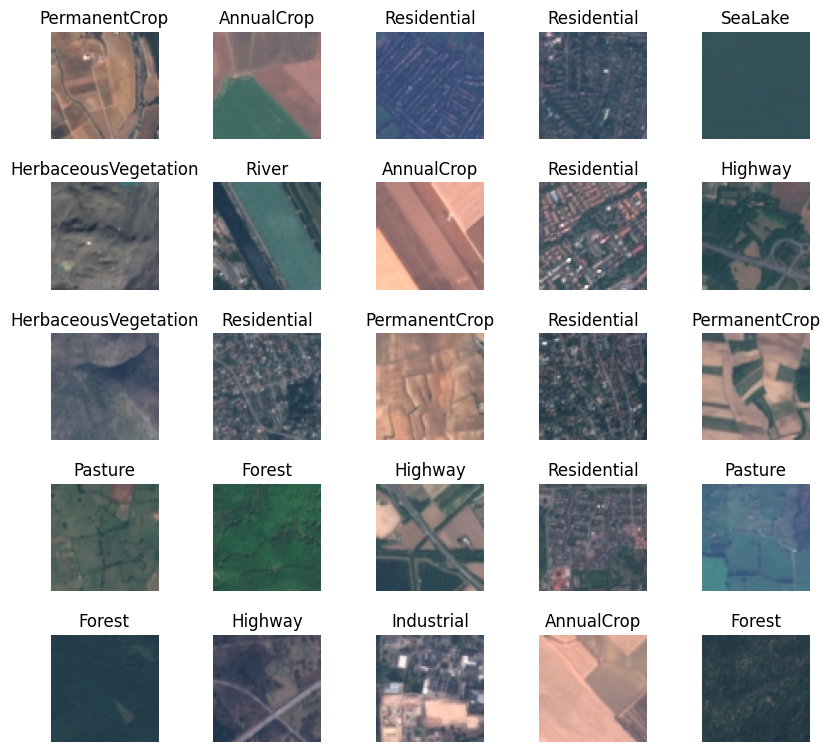

In [40]:
print(f"{EPOCH_COUNT=}, {CLASSES_COUNT=}")
print(f"{BATCH_SIZE=}, {BATCHES_COUNT=}")
print(f"{TRAIN_COUNT=}, {TEST_COUNT=}")

figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = int(torch.randint(len(dataset), size=(1,)).item())
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    figure.tight_layout()
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [8]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        # [BATCH_SIZE, 3, 64, 64]
        self.conv1 = nn.Conv2d(3, 4, 8, padding="same")
        self.pool = nn.MaxPool2d(kernel_size=2)
        # [BATCH_SIZE, 4, 32, 32]
        self.conv2 = nn.Conv2d(4, 8, 4, padding="same")
        # self.pool
        # [BATCH_SIZE, 8, 16, 16]
        self.conv3 = nn.Conv2d(8, 16, 2, padding="same")
        # self.pool
        # [BATCH_SIZE, 16, 8, 8]
        self.fc1 = nn.Linear(16 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [118]:
model = Model()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCH_COUNT):
    epoch_start = time.monotonic()
    epoch_loss = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    epoch_duration = time.monotonic() - epoch_start
    print(f"[{epoch=}, {epoch_duration:.2f}s] loss: {epoch_loss/TRAIN_COUNT:.3f}")

[epoch=0, 27.50s] loss: 0.046
[epoch=1, 27.05s] loss: 0.031
[epoch=2, 27.24s] loss: 0.028
[epoch=3, 27.34s] loss: 0.025
[epoch=4, 27.03s] loss: 0.024
[epoch=5, 27.06s] loss: 0.023
[epoch=6, 27.05s] loss: 0.022
[epoch=7, 27.00s] loss: 0.022
[epoch=8, 27.11s] loss: 0.021
[epoch=9, 27.38s] loss: 0.020


In [9]:
PATH = './cifar_net.pth'
#torch.save(model.state_dict(), PATH)

model = Model()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Accuracy for class: AnnualCrop is 93.5 %
Accuracy for class: Forest is 95.1 %
Accuracy for class: HerbaceousVegetation is 91.0 %
Accuracy for class: Highway is 77.7 %
Accuracy for class: Industrial is 94.9 %
Accuracy for class: Pasture is 80.8 %
Accuracy for class: PermanentCrop is 71.7 %
Accuracy for class: Residential is 87.2 %
Accuracy for class: River is 72.7 %
Accuracy for class: SeaLake is 97.2 %


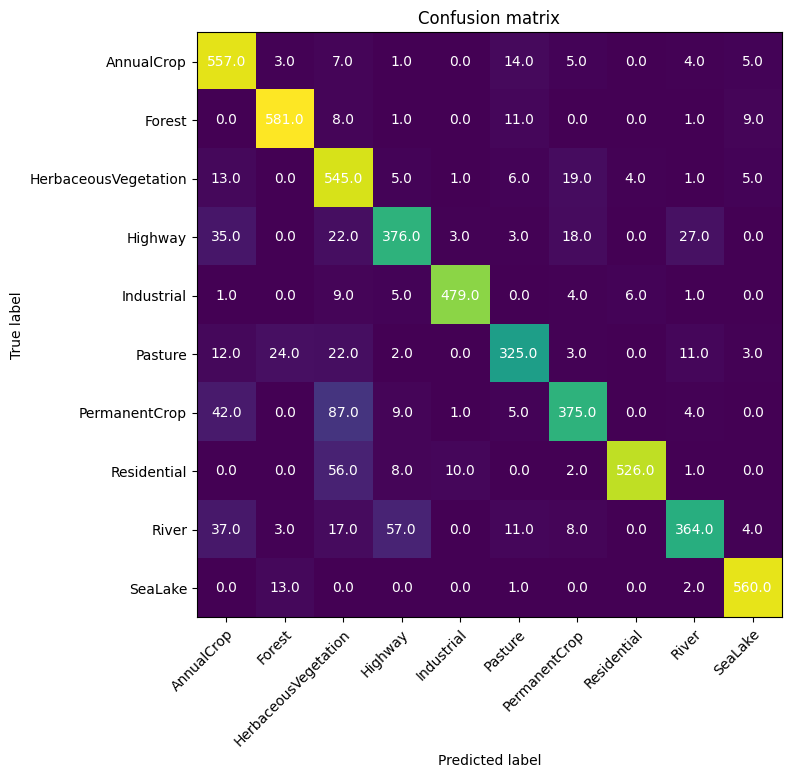

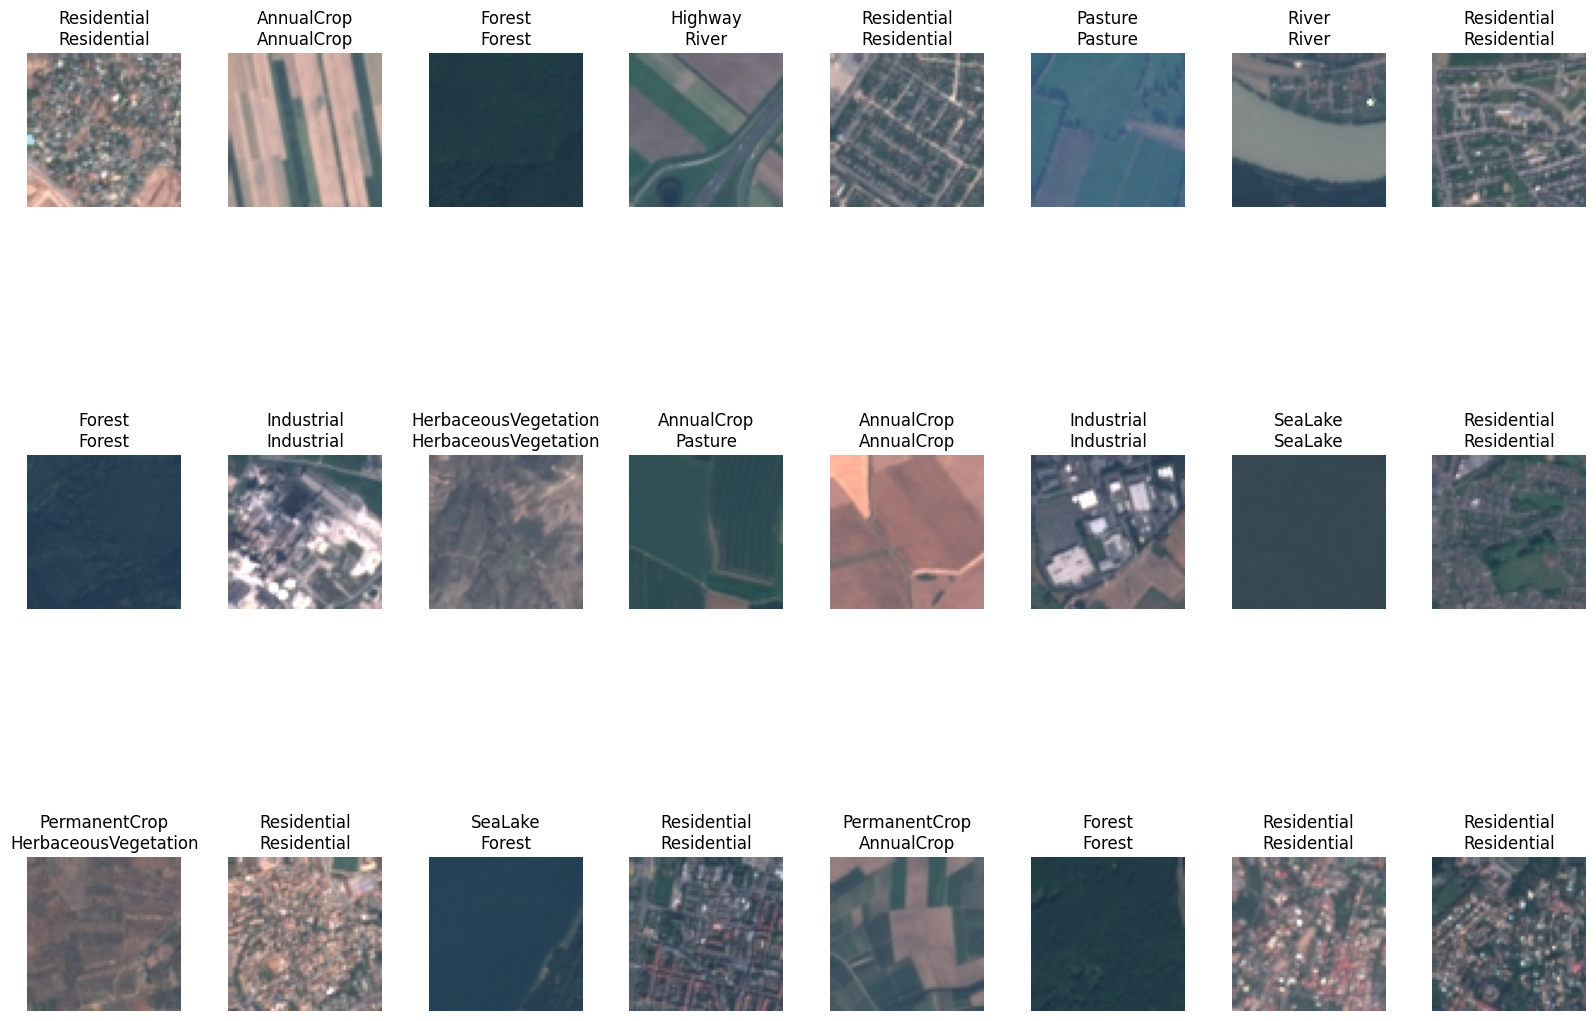

In [41]:
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


classes = dataset.classes
dataiter = iter(test_loader)
images, labels = next(dataiter)

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

conf_mat = np.zeros((CLASSES_COUNT, CLASSES_COUNT))

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            conf_mat[label][prediction] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(conf_mat)

ax.set_xticks(np.arange(CLASSES_COUNT), labels=classes)
ax.set_yticks(np.arange(CLASSES_COUNT), labels=classes)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for (row, col), val in np.ndenumerate(conf_mat):
    ax.text(col, row, val, ha="center", va="center", color="w")

ax.set_title("Confusion matrix")
fig.tight_layout()
plt.show()

figure = plt.figure(figsize=(16, 16))
for i in range(len(images)):
    figure.add_subplot(4, 8, i+1)
    figure.tight_layout()
    plt.title(f"{classes[labels[i]]}\n{classes[predictions[i]]}")
    plt.axis("off")
    img = images[i] * 0.5 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()